Plotting TOP500 systems by country (en)...
Plotting TOP500 systems by process family (en)...


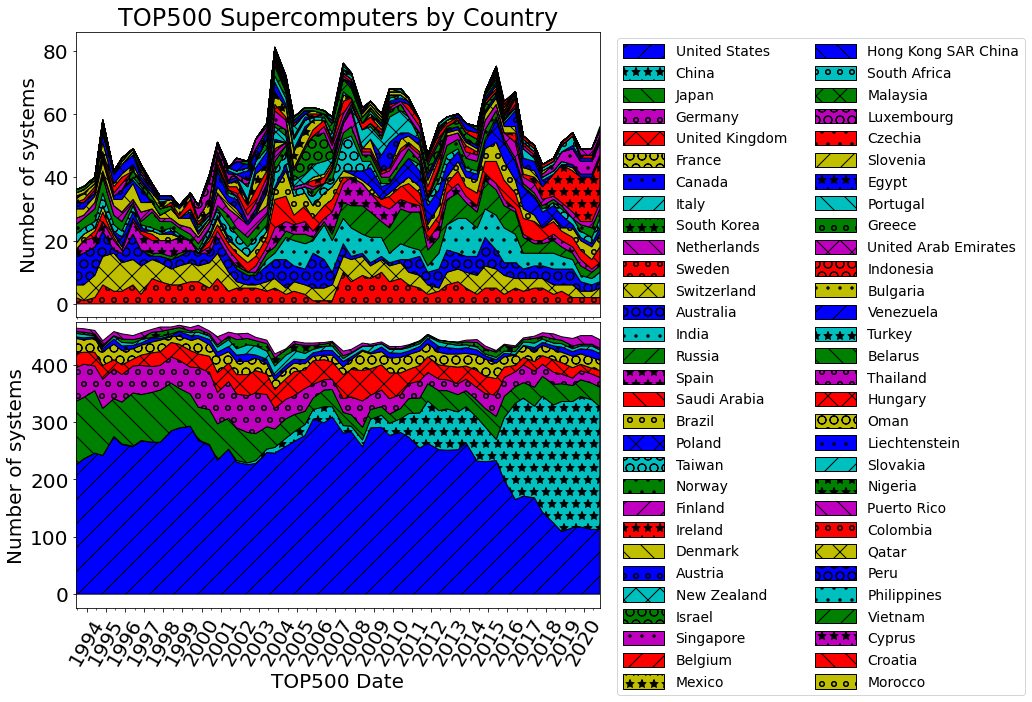

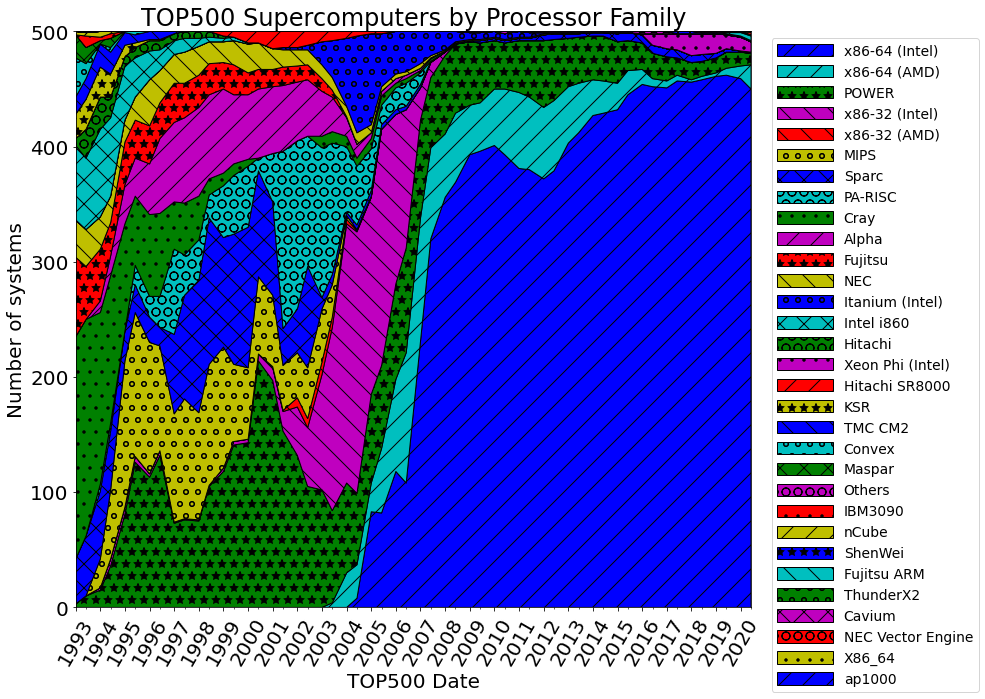

In [45]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import sys, json
from itertools import cycle, product
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, dates as mpld, use

plt.rcParams['font.size']=20
plt.rcParams['svg.fonttype'] = 'none' # don't embed or render font (https://stackoverflow.com/a/35734729)
#pl.rcParams['legend.fontsize']*=1.1
#pl.rcParams['xtick.labelsize']*=1.25
#pl.rcParams['ytick.labelsize']*=1.25
plt.rcParams['legend.fontsize']='x-small'

##########################

# get the data
df = pd.read_csv('TOP500_history.csv', low_memory=False, parse_dates={'Date': ['Year','Month','Day']})
assert (df.groupby(['Date']).size()==500).all()

# Make mostly-coherent processor family and vendor columns
def remap(procfam):
    if procfam in ('Intel EM64T','Intel Nehalem','Intel Westmere','Intel SandyBridge','Intel IvyBridge','Intel Haswell','Intel Core','Intel Broadwell','Intel Skylake','Intel Cascade Lake','Intel Cascade lake','AMD x86_64','AMD Zen (Naples)','AMD Zen-2 (Rome)'):
        i,v='x86-64', procfam.split()[0]
    elif procfam in ('Intel MIC','Intel Xeon Phi'):
        i,v='Xeon Phi','Intel'
    elif procfam in ('POWER','Power','PowerPC'):
        i=v='POWER'
    elif procfam == 'Intel IA-64':
        i,v='Itanium', 'Intel'
    elif procfam in ('Intel IA-32','AMD'):
        i,v='x86-32', procfam.split()[0]
    else:
        i,v=procfam, procfam
    return pd.Series((i,v))

procfam = df['Processor Family'].where(df['Processor Family'].notna(), df['Processor Technology'])
df[['ISA','Vendor']] = procfam.apply(remap)

# get country codes
for f, t in (('Saudia Arabia', 'Saudi Arabia'),     # typo in TOP500 sources
             ('Korea, South', 'South Korea'),       # Match country-en.csv
             ('Czech Republic', 'Czechia'),         # Match country-en.csv
             ('Slovak Republic', 'Slovakia'),       # Match country-en.csv
             ('Hong Kong', 'Hong Kong SAR China')): # Match country-en.csv
    df['Country'].replace(f, t, inplace=True)
dfc_en = pd.read_csv('data/country-en.csv')
dfc_en.columns = ('CountryISO', 'Country')
df = df.merge(dfc_en, on='Country', how='left')
assert (df['CountryISO'].isnull()==False).all()

# get localized labels and countries
loclabels = json.load(open('labels-i18n.json'))
countries = None
for lang in loclabels:
    clang = pd.read_csv('data/country-%s.csv'%lang, encoding='utf-8')
    clang.columns = ('CountryISO', lang)
    if countries is None:
        countries = clang
    else:
        countries = countries.merge(clang, on='CountryISO')
countries.set_index('CountryISO', inplace=True)

assert (df.groupby(['Date']).size()==500).all()

##########################

# Find what set of countries (sorted by weight) account for most of the total counts
country_by_date = df.groupby(['Date','CountryISO']).size()
country_wt = country_by_date.sum(level='CountryISO').sort_values(ascending=False).to_frame('sum')
#country_wt['sum'] = country_by_date.sum(level='Country')
cutoff = country_wt['sum'].cumsum() > 0.90*country_wt['sum'].sum()

#country_by_date = country_by_date.reset_index()
#country_by_date = country_by_date.groupby(('Date','Country')).sum()
country_by_date = country_by_date.unstack()             # pivot Country from row to column index
country_by_date = country_by_date.fillna(0)                # fill in missing values (e.g. x86_64 in 1993 ;-))
major_minor_countries = [ country_by_date.reindex(columns=country_wt.index[cutoff==polarity])
                          for polarity in (False,True) ]

# plot it
del loclabels['fr']
del loclabels['es']

for lang, langlabels in loclabels.items():
    colors = cycle( list('bcgmry') )
    hatches = cycle(('/', '*', '\\', 'o', 'x', 'O', '.'))
    print("Plotting TOP500 systems by country (%s)..." % lang)

    fig = plt.figure(figsize=(14,10))
    sharex = None
    patches, labels = [], []
    dates = country_by_date.index
    for pos, cbd in enumerate(major_minor_countries):
        plt.subplot(2, 1, 2-pos, sharex=sharex)
        sharex = ax = fig.gca()

        edge = 0
        bottom = None
        for pp, ser in cbd.items():
            hatch = next(hatches)
            facecolor = next(colors)

            label = countries.loc[pp,lang]

            ax.fill_between(dates, edge, edge+ser, edgecolor='k', facecolor=facecolor, hatch=hatch, label=label)
            ax.xaxis.set_major_formatter(mpld.DateFormatter("%Y")) #"’%y"))
            ax.xaxis.set_major_locator(mpld.YearLocator())
            ax.xaxis.set_minor_locator(mpld.YearLocator(month=7))
            plt.xticks(rotation='60')
            patches.append( plt.Rectangle((0,0), 2, 2, edgecolor='k', facecolor=facecolor, hatch=hatch) )
            labels.append(label)

            edge += ser

        # show legend and labels
        plt.ylabel(langlabels['nsys'])
        plt.ylim(bottom, min(500, edge.max() + 0.1*np.ptp(edge)))
        if pos==0:
            plt.xlabel(langlabels['date'])
        elif pos==1:
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_xlabel(), visible=False)
            plt.title(langlabels['by_country'])

    plt.legend(patches, labels, loc='upper left', bbox_to_anchor=(1.02, 1), handleheight=1.2, handlelength=3, ncol=2)
    plt.subplots_adjust(left=.08, top=.92, bottom=0.12, right=0.6, hspace=0.02)
    plt.xlim(dates.min(), dates.max())
#     plt.savefig("Countries_with_TOP500_supercomputers_%s.png"%lang, bbox_inches='tight')
#     plt.savefig("Countries_with_TOP500_supercomputers_%s.svg"%lang, bbox_inches='tight')

##########################

# Processor families by date, sorted by weight of ISA then by Vendor
proc_counts = df.groupby(['ISA','Vendor','Date']).size()
proc_by_date = proc_counts.unstack(level=(0,1)).fillna(0) # pivot ISA,Vendor from row to column index
proc_wt = proc_by_date.sum().to_frame()                   # weight (ISA,Vendor) across all dates
ISA_wt = proc_wt.sum(level='ISA')                         # weight by (ISA) across all dates
ISA_wt.columns = [1]
proc_wt = proc_wt.join( ISA_wt.reindex(proc_wt.index, level='ISA') )
proc_wt.sort_values([1,0], ascending=(False,False), inplace=True)
proc_by_date = proc_by_date.reindex(columns=proc_wt.index)

# plot it
for lang, langlabels in loclabels.items():
    colors = cycle( list('bcgmry') )
    hatches = cycle(('/', '*', '\\', 'o', 'x', 'O', '.'))
    print("Plotting TOP500 systems by process family (%s)..." % lang)

    fig = plt.figure(figsize=(14,10))
    patches, labels = [], []
    dates = proc_by_date.index
    edge = 0

    pplast = facecolor = bottom = None
    for pp, ser in proc_by_date.items():

        #print ser.shape, edge.shape, dates.shape
        if isinstance(pp, str): pp=pp,
        if pplast is None or pp[0]!=pplast[0]:
            hatch = next(hatches)
        if pplast is None or len(pp)<2 or pp[1]!=pplast[1]:
            facecolor = next(colors)
        label = ("%s (%s)"%pp if pp[0]!=pp[1] else pp[0])

        ax = fig.gca()
        ax.fill_between(dates, edge, edge+ser, edgecolor='k', facecolor=facecolor, hatch=hatch, label=label)
        ax.xaxis.set_major_formatter(mpld.DateFormatter("%Y")) #"’%y"))
        ax.xaxis.set_major_locator(mpld.YearLocator(month=6))
        ax.xaxis.set_minor_locator(mpld.YearLocator(month=11))
        plt.xticks(rotation=60)
        patches.append( plt.Rectangle((0,0), 2, 2, edgecolor='k', facecolor=facecolor, hatch=hatch) )
        labels.append(label)

        edge += ser
        pplast = pp
        if bottom is None:
            bottom = max(0, edge.min() - 0.1*np.ptp(edge))

    # show legend and labels
    plt.legend(patches, labels, loc='upper left', bbox_to_anchor=(1.02, 1), handleheight=1, handlelength=4)
    plt.subplots_adjust(left=.08, top=.92, bottom=0.12, right=0.75)
    plt.xlabel(langlabels['date'])
    plt.ylabel(langlabels['nsys'])
    plt.title(langlabels['by_procfam'])

    plt.xlim(dates.min(), dates.max())#+pd.datetools.relativedelta(months=6))
    plt.ylim(bottom, min(500, edge.max() + 0.1*np.ptp(edge)))

#     plt.savefig("Processor_families_in_TOP500_supercomputers_%s.png"%lang, bbox_inches='tight')
#     plt.savefig("Processor_families_in_TOP500_supercomputers_%s.svg"%lang, bbox_inches='tight')

#plt.show()


In [41]:
loclabels

{'fr': {'nsys': 'Nombre de systÃ¨mes',
  'by_procfam': 'Superordinateurs TOP500 par famille de processeur',
  'by_country': 'Superordinateurs TOP500 par pays',
  'date': 'Date de la liste TOP500'},
 'en': {'nsys': 'Number of systems',
  'by_procfam': 'TOP500 Supercomputers by Processor Family',
  'by_country': 'TOP500 Supercomputers by Country',
  'date': 'TOP500 Date'},
 'es': {'nsys': 'NÃºmero de sistemas',
  'by_procfam': 'Supercomputadoras de TOP500 por familia de procesora',
  'by_country': 'Supercomputadoras de TOP500 por paÃ\xads',
  'date': 'Fecha de la lista TOP500'}}

In [35]:
df

,Date,Rank,Site,Manufacturer,Computer,Country,Processors,RMax,RPeak,Nmax,...,HPCG [TFlop/s],Power (kW),Power Effeciency [GFlops/Watts],Site ID,System ID,Power Efficiency [GFlops/Watts],Memory,ISA,Vendor,data/CountryISO
0,1993-06-01,1.0,Los Alamos National Laboratory,Thinking Machines Corporation,CM-5/1024,United States,1024.0,59.7,131.00,52224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sparc,Sparc,US
1,1993-06-01,2.0,Minnesota Supercomputer Center,Thinking Machines Corporation,CM-5/544,United States,544.0,30.4,69.63,36864.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sparc,Sparc,US
2,1993-06-01,3.0,NCSA,Thinking Machines Corporation,CM-5/512,United States,512.0,30.4,65.54,36864.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sparc,Sparc,US
3,1993-06-01,4.0,National Security Agency,Thinking Machines Corporation,CM-5/512,United States,512.0,30.4,65.54,36864.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sparc,Sparc,US
4,1993-06-01,5.0,NEC,NEC,SX-3/44R,Japan,4.0,23.2,25.60,6400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEC,NEC,JP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,2020-11-01,496.0,Central Research Institute of Electric Power I...,HPE,"HPE SGI 8600, Xeon Gold 6148 20C 2.4GHz, 4xEDR...",Japan,NaN,NaN,NaN,2525184.0,...,NaN,357.55,NaN,47530.0,179563.0,3.709271,NaN,x86-64,Intel,JP
27996,2020-11-01,497.0,National Center for High Performance Computing,Fujitsu,"PRIMERGY CX2550 M4/CX2560 M4/CX2570 M4, Xeon G...",Taiwan,NaN,NaN,NaN,3707904.0,...,NaN,332.00,NaN,48468.0,179170.0,3.991416,NaN,x86-64,Intel,TW
27997,2020-11-01,498.0,Service Provider T,Lenovo,"Lenovo HR650x, Xeon Gold 6133 20C 2.5GHz, 25G ...",China,NaN,NaN,NaN,3794688.0,...,NaN,NaN,NaN,50329.0,179352.0,NaN,NaN,x86-64,Intel,CN
27998,2020-11-01,499.0,Service Provider T,Lenovo,"Lenovo HR650x, Xeon Gold 6133 20C 2.5GHz, 25G ...",China,NaN,NaN,NaN,3794688.0,...,NaN,NaN,NaN,50329.0,179353.0,NaN,NaN,x86-64,Intel,CN


In [33]:
df

,Date,Rank,Site,Manufacturer,Computer,Country,Processors,RMax,RPeak,Nmax,...,Power (kW),Power Effeciency [GFlops/Watts],Site ID,System ID,Power Efficiency [GFlops/Watts],Memory,ISA,Vendor,data/CountryISO_x,data/CountryISO_y
0,1993-06-01,1.0,Los Alamos National Laboratory,Thinking Machines Corporation,CM-5/1024,United States,1024.0,59.7,131.00,52224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Sparc,Sparc,US,US
1,1993-06-01,2.0,Minnesota Supercomputer Center,Thinking Machines Corporation,CM-5/544,United States,544.0,30.4,69.63,36864.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Sparc,Sparc,US,US
2,1993-06-01,3.0,NCSA,Thinking Machines Corporation,CM-5/512,United States,512.0,30.4,65.54,36864.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Sparc,Sparc,US,US
3,1993-06-01,4.0,National Security Agency,Thinking Machines Corporation,CM-5/512,United States,512.0,30.4,65.54,36864.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Sparc,Sparc,US,US
4,1993-06-01,5.0,NEC,NEC,SX-3/44R,Japan,4.0,23.2,25.60,6400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NEC,NEC,JP,JP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,2020-11-01,496.0,Central Research Institute of Electric Power I...,HPE,"HPE SGI 8600, Xeon Gold 6148 20C 2.4GHz, 4xEDR...",Japan,NaN,NaN,NaN,2525184.0,...,357.55,NaN,47530.0,179563.0,3.709271,NaN,x86-64,Intel,JP,JP
27996,2020-11-01,497.0,National Center for High Performance Computing,Fujitsu,"PRIMERGY CX2550 M4/CX2560 M4/CX2570 M4, Xeon G...",Taiwan,NaN,NaN,NaN,3707904.0,...,332.00,NaN,48468.0,179170.0,3.991416,NaN,x86-64,Intel,TW,TW
27997,2020-11-01,498.0,Service Provider T,Lenovo,"Lenovo HR650x, Xeon Gold 6133 20C 2.5GHz, 25G ...",China,NaN,NaN,NaN,3794688.0,...,NaN,NaN,50329.0,179352.0,NaN,NaN,x86-64,Intel,CN,CN
27998,2020-11-01,499.0,Service Provider T,Lenovo,"Lenovo HR650x, Xeon Gold 6133 20C 2.5GHz, 25G ...",China,NaN,NaN,NaN,3794688.0,...,NaN,NaN,50329.0,179353.0,NaN,NaN,x86-64,Intel,CN,CN
